In [3]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import copy
import joblib
import shap
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_auc_score,  make_scorer, fbeta_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Constants
lr = 5e-4
weight_decay = 1e-4
batch_size = 64
num_epochs = 75
num_runs = 5
max_patience = 13

# pd 
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 0)

Using device: cuda


In [4]:
def load_datasets(base_path="./"):
    
    files = {"train": "cs-training.csv"}
    dfs = {}
    
    for key, filename in files.items():
        print(f"Loading {filename}...")
        dfs[key] = pd.read_csv(base_path + filename, index_col=0)
        print(f"Loaded {filename} with {len(dfs[key].columns)} columns")
        
    return dfs

def dataset_summary(df, y=None, threshold=0.7):
    
    df_copy = df.copy()

    if y is not None and y.name in df_copy.columns:
        df_copy = df_copy.drop(columns=[y.name])
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df_copy[col] = df_copy[col].astype("category").cat.codes
        
    numeric_cols = df_copy.select_dtypes(include="number").columns
    imputed_flags = [col for col in numeric_cols if col.startswith("Was") or col.endswith("Imputed")]
    regular_numeric_cols = [col for col in numeric_cols if col not in imputed_flags]

    df_num = df_copy[regular_numeric_cols].copy()
    
    df_num.replace([np.inf, -np.inf], np.nan, inplace=True)

    print(f"Dataset shape: {df_num.shape}")
    print(f"Total rows: {len(df_num)}")
    print(f"Total duplicate rows: {df_num.duplicated().sum()}")

    desc = df_num.describe().T
    desc["skew"] = df_num.skew()
    
    desc["dtype"] = df_copy[desc.index].dtypes
    desc["non_null"] = df_copy[desc.index].notna().sum()
    desc["missing"] = df_copy[desc.index].isna().sum()
    desc["missing_%"] = (df_copy[desc.index].isna().mean() * 100).round(2)
    desc["unique"] = df_copy[desc.index].nunique()
    
    if y is not None:
        df_num['target'] = y
        desc["corr_with_target"] = df_num.corr()['target'].drop('target')
    
    corr_matrix = df_copy.corr(numeric_only=True)
       
    corr_pairs = (
        corr_matrix
        .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .sort_values(ascending=False)
    )
      
    high_corr = corr_pairs[abs(corr_pairs) > threshold]
     
    corr_map = {}
    for (f1, f2), val in high_corr.items():
        corr_map.setdefault(f1, []).append(f"{f2} ({val:.2f})")
        corr_map.setdefault(f2, []).append(f"{f1} ({val:.2f})")
    
    high_corr_flags = []
    high_corr_with = []
    
    for col in desc.index:
        if col in corr_map:
            high_corr_flags.append(True)
            high_corr_with.append(", ".join(corr_map[col]))
        else:
            high_corr_flags.append(False)
            high_corr_with.append("")
    
    desc["high_corr_flag"] = high_corr_flags
    desc["high_corr_with"] = high_corr_with
    
    return desc.sort_values("missing_%", ascending=False)

def outlier_handling(X, y, n_high=100, n_low=10):
    
    X_copy = X.copy()
    y_copy = y.copy()
    
    numeric_cols = X_copy.select_dtypes(include=["number"]).columns.tolist()
    X_copy[numeric_cols] = X_copy[numeric_cols].fillna(0)

    hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42,
        min_samples_leaf=20
    )
    hgb.fit(X_copy, y_copy)
    y_pred_proba = hgb.predict_proba(X_copy)[:, 1]

    df_combined = X_copy.copy()
    df_combined["__pred_proba__"] = y_pred_proba
    df_combined["__target__"] = y_copy.values  # keep target with same index

    df_sorted = df_combined.sort_values("__pred_proba__", ascending=True).reset_index(drop=True)

    total_rows = len(df_sorted)
    start_idx = n_low
    end_idx = max(0, total_rows - n_high)

    df_filtered = df_sorted.iloc[start_idx:end_idx].reset_index(drop=True)

    dropped = total_rows - len(df_filtered)
    print(f"Dropped {dropped} outlier rows (lowest {n_low}, highest {n_high})")

    X_filtered = df_filtered.drop(columns=["__pred_proba__", "__target__"])
    y_filtered = df_filtered["__target__"]

    return X_filtered, y_filtered

def drop_target_and_ids(df):
    
    df_copy = df.copy()
    
    feature_cols_to_drop = ["SeriousDlqin2yrs"]
    target = df_copy["SeriousDlqin2yrs"]
    df_raw_features = df_copy.drop(columns=feature_cols_to_drop)
    
    print(f"Dropped cols: {feature_cols_to_drop}")
    
    return df_raw_features, target, feature_cols_to_drop

def engineer_features(df):
    
    df_e = df.copy()

    NumberOfTime3059DaysPastDueNotWorse = df_e["NumberOfTime30-59DaysPastDueNotWorse"].fillna(0).clip(upper=10)
    NumberOfTimes90DaysLate = df_e["NumberOfTimes90DaysLate"].fillna(0).clip(upper=10)
    NumberOfTime6089DaysPastDueNotWorse = df_e["NumberOfTime60-89DaysPastDueNotWorse"].fillna(0).clip(upper=10)

    TotalPastDue = (
        NumberOfTime3059DaysPastDueNotWorse
        + NumberOfTimes90DaysLate
        + NumberOfTime6089DaysPastDueNotWorse
    )
    
    TotalPastDueCapped = TotalPastDue.clip(upper=10)
    
    RevolvingUtilizationCapped = df_e["RevolvingUtilizationOfUnsecuredLines"].clip(upper=5.0)
    RevolvingUtilizationFilled = RevolvingUtilizationCapped.fillna(0.0)
    RevolvingUtilizationCappedLog = np.log1p(RevolvingUtilizationFilled).replace(0, np.nan)
        
    AgeSafe = df_e["age"].replace(0, np.nan)

    DebtRatioCapped = df_e["DebtRatio"].clip(upper=10000.0)

    CreditLinesSafe = df_e["NumberOfOpenCreditLinesAndLoans"].replace(0, np.nan)

    DebtToIncome = DebtRatioCapped * df_e["MonthlyIncome"]
    
    IncomePerCreditLine = df_e["MonthlyIncome"] / CreditLinesSafe

    AgeRisk = np.where(AgeSafe < 25, 1.0,
                 np.where(AgeSafe < 35, 0.8,
                 np.where(AgeSafe < 50, 0.6, 0.4)))

    DelinquencyScore = (
        NumberOfTime3059DaysPastDueNotWorse +
        NumberOfTime6089DaysPastDueNotWorse * 2 +
        NumberOfTimes90DaysLate * 3
    )

    UtilizationPerAge = RevolvingUtilizationCappedLog / AgeSafe

    HasAnyDelinquency = (TotalPastDueCapped > 0).astype(int)

    df_e["RevolvingUtilizationCappedLog"] = RevolvingUtilizationCappedLog
    df_e["TotalPastDueCapped"] = TotalPastDueCapped

    df_e["DelinquencyScore"] = DelinquencyScore
    df_e["HasMajorDelinquency"] = (
        (NumberOfTime6089DaysPastDueNotWorse > 0) |
        (NumberOfTimes90DaysLate > 0)
    ).astype(int)

    df_e["UtilizationPerAge"] = UtilizationPerAge
    df_e["UtilizationTimesDelinquency"] = UtilizationPerAge * HasAnyDelinquency
    df_e["LatePaymentsPerCreditLine"] = TotalPastDue / CreditLinesSafe
    df_e["UtilizationPerCreditLine"] = RevolvingUtilizationCappedLog / CreditLinesSafe

    df_e["IncomePerCreditLine"] = IncomePerCreditLine
    df_e["DebtToIncomeAgeRisk"] = DebtToIncome * AgeRisk

    df_e["HighAgeRiskFlag"] = (AgeRisk <= 0.4).astype(int)

    DelinquencyScore_bins = [-1, 0, 1, 3, 6, np.inf]
    DelinquencyScore_labels = ["None", "Few", "Moderate", "Frequent", "Chronic"]
    df_e["DelinquencyBucket"] = pd.cut(DelinquencyScore, bins=DelinquencyScore_bins, labels=DelinquencyScore_labels)

    Utilization_bins = [-0.01, 0.1, 0.3, 0.6, 0.9, 1.5, 10]
    Utilization_labels = ["Very Low", "Low", "Moderate", "High", "Very High", "Extreme"]
    UtilizationBucket = pd.cut(RevolvingUtilizationFilled, bins=Utilization_bins, labels=Utilization_labels)

    Late_bins = [-1, 0, 1, 3, 6, np.inf]
    Late_labels = ["NoLate", "FewLate", "ModerateLate", "FrequentLate", "ChronicLate"]
    LatePaymentBucket = pd.cut(TotalPastDue, bins=Late_bins, labels=Late_labels)

    df_e["UtilizationBucketLateBucket"] = (
        UtilizationBucket.astype(str) + "_" + LatePaymentBucket.astype(str)
    )

    engineered_cols = [
        "TotalPastDueCapped",
        "DelinquencyScore",
        "HasMajorDelinquency",
        "UtilizationPerAge",
        "LatePaymentsPerCreditLine",
        "IncomePerCreditLine",
        "DebtToIncomeAgeRisk",
        "DelinquencyBucket",
        "UtilizationBucketLateBucket",
        "UtilizationPerCreditLine",
        "UtilizationTimesDelinquency",
        "HighAgeRiskFlag",
        "RevolvingUtilizationCappedLog"
    ]

    engineered_df = df_e[engineered_cols]

    print(f"Engineered {len(engineered_df)} features")
    print(f"Engineered cols: {list(engineered_df.columns)}")

    return engineered_df

def drop_high_missing_cols(df, threshold=0.3):

    missing_frac = df.isna().mean().sort_values(ascending=False)
    missing_summary = pd.DataFrame({
        'MissingCount': df.isna().sum(),
        'MissingPercent': (missing_frac * 100).round(2)
    })

    if df.isna().sum().sum() > 0:
        print(missing_summary.to_string())
    
    hm_cols_to_drop = missing_frac[missing_frac > threshold].index.tolist()
    
    if hm_cols_to_drop:
        df_drop = df.drop(columns=hm_cols_to_drop)
        print(f"Dropped: {len(hm_cols_to_drop)} high missing cols")
        print(f"Dropped cols: {hm_cols_to_drop}")
    else:
        df_drop = df.copy()
        print("No high missing cols dropped")
        
    return df_drop, hm_cols_to_drop

def drop_high_card_cols(df, threshold=50):

    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    unique_counts = df[cat_cols].nunique().sort_values(ascending=False)
    unique_summary = pd.DataFrame({
        'UniqueCount': unique_counts,
        'UniquePercent': (unique_counts / len(df) * 100).round(2)
    })

    if cat_cols:
        print(unique_summary.to_string())

    hc_cols_to_drop = unique_counts[unique_counts > threshold].index.tolist()

    if hc_cols_to_drop:
        df_high = df.drop(columns=hc_cols_to_drop, errors='ignore')
        print(f"Dropped: {len(hc_cols_to_drop)} high cardinality cols")
        print(f"Dropped cols: {hc_cols_to_drop}")
    else:
        df_high = df.copy()
        print("No high cardinality cols dropped")

    return df_high, hc_cols_to_drop

def collapse_rare_categories(df, threshold=0.005):
    
    df_copy = df.copy()
    
    cat_cols = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()
    
    rare_maps = {}

    for col in cat_cols:
        freqs = df_copy[col].value_counts(normalize=True, dropna=True)
        rare_cats = [c for c in freqs[freqs < threshold].index]
        if rare_cats:
            df_copy[col] = df_copy[col].astype('object').replace(rare_cats, 'Other')
            rare_maps[col] = set(rare_cats)
            print(f"Column '{col}': collapsed {len(rare_cats)} rare categories: {rare_cats}")
        else:
            print(f"Column '{col}': no rare categories to collapse")

    return df_copy, rare_maps

def select_features(df, target, n_to_keep=10):
    
    df_temp = df.copy()
    
    cat_cols = df_temp.select_dtypes(include=["object", "category"]).columns.tolist()
    df_model = df_temp.copy()
    for col in cat_cols:
        df_model[col] = df_model[col].astype("category").cat.codes

    feature_cols = df_model.columns.tolist()

    X_train, _, y_train, _ = train_test_split(
        df_model[feature_cols],
        target,
        test_size=0.2,
        random_state=42,
        stratify=target,
    )

    X_train = X_train.astype(np.float32)

    best_param = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "scale_pos_weight": sum(y_train==0)/sum(y_train==1),
        "learning_rate": 0.02,
        "max_depth": 4,
        "min_child_weight": 5,
        "subsample": 0.85,
        "colsample_bytree": 0.85,
        "gamma": 1,
        "reg_alpha": 1,
        "reg_lambda": 2,
        "n_estimators": 1000,
        "random_state": 42,
        "n_jobs": -1,
        "tree_method": "hist", 
        "device": "cuda",
    }

    model = xgb.XGBClassifier(
        **best_param,
    )
    
    model.fit(X_train, y_train, verbose=False)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    
    importance_df = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": mean_abs_shap
    }).sort_values("Importance", ascending=False).reset_index(drop=True)

    top_features = importance_df["Feature"].head(n_to_keep).tolist()

    final_features = list(set(top_features + cat_cols))

    dropped_features = [f for f in df_temp.columns if f not in final_features]

    print(f"Kept {len(final_features)} features (including categorical columns)")
    print(f"Dropped {len(dropped_features)} features")
    if dropped_features:
        print(f"Dropped cols: {dropped_features}")
    print(importance_df)

    return df_temp[final_features].copy(), dropped_features

def impute_and_scale(df):
    
    df_copy = df.copy()
    
    num_imputer = None
    robust_scaler = None
    std_scaler = None
    cat_imputer=None
    cat_maps = {}
    skewed_cols = []

    num_col_order = df_copy.select_dtypes(include=['number']).columns.tolist()
    cat_col_order = df_copy.select_dtypes(include=['object', 'category']).columns.tolist()

    if num_col_order:
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        num_imputer = SimpleImputer(strategy='median')
        df_copy[num_col_order] = num_imputer.fit_transform(df_copy[num_col_order])
        skewness = df_copy[num_col_order].skew().sort_values(ascending=False)
        skewed_cols = skewness[abs(skewness) > 1.0].index.tolist()
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols:
            robust_scaler = RobustScaler()
            df_copy[skewed_cols] = robust_scaler.fit_transform(df_copy[skewed_cols])
        if normal_cols:
            std_scaler = StandardScaler()
            df_copy[normal_cols] = std_scaler.fit_transform(df_copy[normal_cols])

    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object') 
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df_copy[cat_col_order] = cat_imputer.fit_transform(df_copy[cat_col_order]) 
        for col in cat_col_order:
            unique_cats = df_copy[col].astype(str).unique()
            cat_maps[col] = {cat: idx for idx, cat in enumerate(unique_cats)}

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_cols, cat_col_order, cat_maps, imputed_flags

def transform_val_test(
    df, 
    cols_to_drop=None, 
    num_imputer=None,
    cat_imputer=None,
    robust_scaler=None, 
    std_scaler=None,
    num_col_order=None, 
    skewed_cols=None,
    cat_col_order=None,
    rare_maps=None,
    train_columns=None
):
    
    df_copy = df.copy()

    if cols_to_drop:
        df_copy = df_copy.drop(columns=cols_to_drop, errors='ignore')

    if num_col_order:     
        df_copy[num_col_order] = df_copy[num_col_order].replace([np.inf, -np.inf], np.nan)
        for col in num_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        df_copy[num_col_order] = num_imputer.transform(df_copy[num_col_order])
        skewed_cols = skewed_cols or []
        normal_cols = [c for c in num_col_order if c not in skewed_cols]
        if skewed_cols and robust_scaler:
            df_copy[skewed_cols] = robust_scaler.transform(df_copy[skewed_cols])
        if normal_cols and std_scaler:
            df_copy[normal_cols] = std_scaler.transform(df_copy[normal_cols])
            
    if cat_col_order:
        df_copy[cat_col_order] = df_copy[cat_col_order].astype('object')
        for col in cat_col_order:
            df_copy[f'Was{col}Imputed'] = df_copy[col].isna().astype(int)
        for col in cat_col_order:
            if rare_maps and col in rare_maps:
                rare_categories = list(rare_maps[col])
                df_copy[col] = df_copy[col].replace(rare_categories, 'Other')
        df_copy[cat_col_order] = cat_imputer.transform(df_copy[cat_col_order])
   
    if train_columns is not None:
        df_copy = df_copy.reindex(columns=train_columns, fill_value=0)

    imputed_flags = [col for col in df_copy.columns if col.startswith("Was") and col.endswith("Imputed")]

    print("Imputed, flagged, and scaled features")
    
    return df_copy, imputed_flags

def check_and_drop_duplicates(df, target=None):
    
    df_cleaned = df.drop_duplicates()
    
    count = df.duplicated().sum()

    if target is None:
        print(f"Dropped: {count} duplicates")
        return df_cleaned

    target_cleaned = pd.Series(target).reindex(df_cleaned.index)
    mask = target_cleaned.notna()
    df_cleaned = df_cleaned[mask].reset_index(drop=True)
    target_cleaned = target_cleaned[mask].reset_index(drop=True)

    print(f"Dropped: {count} duplicates")
    
    return df_cleaned, target_cleaned

def threshold_by_target_recall(y_true, y_probs, thresholds, target_recall):
    
    y_true = np.asarray(y_true).astype(int)
    y_probs = np.asarray(y_probs).astype(float)
    thresholds = np.asarray(thresholds).astype(float)

    preds = y_probs[:, None] > thresholds[None, :]
    TP = (preds & (y_true[:, None] == 1)).sum(axis=0)
    FN = ((~preds) & (y_true[:, None] == 1)).sum(axis=0)

    recall = TP / (TP + FN + 1e-8)
    closest_idx = np.argmin(np.abs(recall - target_recall))
    
    return thresholds[closest_idx]

In [5]:
# Load datasets
dfs = load_datasets()
df_train = dfs["train"]

Loading cs-training.csv...
Loaded cs-training.csv with 11 columns


In [6]:
# Summary
dataset_summary(df_train, df_train["SeriousDlqin2yrs"])

Dataset shape: (150000, 10)
Total rows: 150000
Total duplicate rows: 646


,count,mean,std,min,25%,50%,75%,max,skew,dtype,non_null,missing,missing_%,unique,corr_with_target,high_corr_flag,high_corr_with
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0,114.040318,float64,120269,29731,19.82,13594,-0.019746,False,
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0,1.588242,float64,146076,3924,2.62,13,0.046048,False,
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0,0.188995,int64,150000,0,0.00,86,-0.115386,False,
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0,97.631574,float64,150000,0,0.00,125728,-0.001802,False,
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0,95.157793,float64,150000,0,0.00,114194,-0.007602,False,
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0,22.597108,int64,150000,0,0.00,16,0.125587,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTimes90DaysLate (0.98)"
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0,1.215314,int64,150000,0,0.00,58,-0.029669,False,
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0,23.087345,int64,150000,0,0.00,19,0.117175,True,"NumberOfTime60-89DaysPastDueNotWorse (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.98)"
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0,3.482484,int64,150000,0,0.00,28,-0.007038,False,
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0,23.331743,int64,150000,0,0.00,13,0.102261,True,"NumberOfTimes90DaysLate (0.99), NumberOfTime30-59DaysPastDueNotWorse (0.99)"


In [7]:
# Drop duplicates
df_train = check_and_drop_duplicates(df_train)

Dropped: 609 duplicates


In [9]:
# Outlier Handling Manual
numeric_df = df_train.select_dtypes(include=['number'])

df_train = df_train[df_train['age'] > 0].reset_index(drop=True) 

df_train = df_train.sort_values(by="MonthlyIncome", ascending=False).iloc[1:].reset_index(drop=True) 

df_train = df_train[df_train['age'] > 0].reset_index(drop=True)

df_train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149388.000000,149388.000000,149388.000000,149388.000000,149388.000000,1.201670e+05,149388.000000,149388.000000,149388.000000,149388.000000,145560.000000
mean,0.067000,6.071202,52.306484,0.393887,354.443855,6.635247e+03,8.480855,0.238125,1.022385,0.212507,0.759845
std,0.250023,250.266184,14.725432,3.852991,2041.863340,1.027023e+04,5.136533,3.826203,1.130204,3.810561,1.116131
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.030134,41.000000,0.000000,0.177445,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154236,52.000000,0.000000,0.368240,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.556494,63.000000,0.000000,0.875317,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,1.560100e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [11]:
# Select targets
df_features, target, feature_cols_to_drop = drop_target_and_ids(df_train)
print(target.value_counts())

Dropped cols: ['SeriousDlqin2yrs']
SeriousDlqin2yrs
0    139379
1     10009
Name: count, dtype: int64


In [12]:
original_cols = df_features.select_dtypes(include=['number']).columns.tolist()
print(original_cols)

['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']


In [13]:
# Split train/test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    df_features, target, test_size=0.2, stratify=target, random_state=42
)

# Outlier Handling 
X_train_cut, y_train_cut = outlier_handling(
    X_train_full,
    y_train_full,
    n_high=130, 
    n_low=30
)

# Split train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_cut, y_train_cut, test_size=0.2, stratify=y_train_cut, random_state=42
)

Dropped 160 outlier rows (lowest 30, highest 130)


In [14]:
# Engineer_features
df_e = engineer_features(X_train)

Engineered 95480 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']


In [15]:
# Drop columns with missing
df_drop, hm_cols_to_drop = drop_high_missing_cols(df_e, threshold=0.25)

                               MissingCount  MissingPercent
DebtToIncomeAgeRisk                       0            0.00
DelinquencyBucket                         0            0.00
DelinquencyScore                          0            0.00
HasMajorDelinquency                       0            0.00
HighAgeRiskFlag                           0            0.00
IncomePerCreditLine                    1081            1.13
LatePaymentsPerCreditLine              1081            1.13
RevolvingUtilizationCappedLog          6792            7.11
TotalPastDueCapped                        0            0.00
UtilizationBucketLateBucket               0            0.00
UtilizationPerAge                      6792            7.11
UtilizationPerCreditLine               7873            8.25
UtilizationTimesDelinquency            6792            7.11
No high missing cols dropped


In [16]:
# Drop high card
df_high, hc_cols_to_drop = drop_high_card_cols(df_drop, threshold=50)

                             UniqueCount  UniquePercent
UtilizationBucketLateBucket           30           0.03
DelinquencyBucket                      5           0.01
No high cardinality cols dropped


In [17]:
# Collapse rare categories
df_collapsed, rare_maps = collapse_rare_categories(df_high, threshold=0.05)

Column 'DelinquencyBucket': collapsed 2 rare categories: ['Frequent', 'Chronic']
Column 'UtilizationBucketLateBucket': collapsed 25 rare categories: ['Very Low_FewLate', 'Very High_FewLate', 'Low_FewLate', 'Very High_ModerateLate', 'Moderate_FewLate', 'High_FewLate', 'High_ModerateLate', 'Moderate_ModerateLate', 'Very High_FrequentLate', 'Very Low_ModerateLate', 'Low_ModerateLate', 'High_FrequentLate', 'Very High_ChronicLate', 'Moderate_FrequentLate', 'Extreme_NoLate', 'Very Low_FrequentLate', 'Low_FrequentLate', 'High_ChronicLate', 'Extreme_ModerateLate', 'Moderate_ChronicLate', 'Extreme_FrequentLate', 'Extreme_FewLate', 'Very Low_ChronicLate', 'Low_ChronicLate', 'Extreme_ChronicLate']


In [18]:
# Feature selection
df_selected, fs_cols_to_drop = select_features(df_collapsed, y_train, n_to_keep=14)

Kept 13 features (including categorical columns)
Dropped 0 features
                          Feature  Importance
0       LatePaymentsPerCreditLine    0.567157
1               UtilizationPerAge    0.521696
2   RevolvingUtilizationCappedLog    0.287650
3                DelinquencyScore    0.273488
4             IncomePerCreditLine    0.184842
5        UtilizationPerCreditLine    0.173317
6             DebtToIncomeAgeRisk    0.167116
7     UtilizationTimesDelinquency    0.155006
8              TotalPastDueCapped    0.090354
9     UtilizationBucketLateBucket    0.046073
10                HighAgeRiskFlag    0.028939
11            HasMajorDelinquency    0.023735
12              DelinquencyBucket    0.018867


In [19]:
# Impute and scale
X_train, num_imputer, cat_imputer, robust_scaler, std_scaler, num_col_order, skewed_col_order, cat_col_order, cat_maps, X_train_flags = impute_and_scale(
    df_selected
)
print(num_col_order)
print(cat_col_order)
print(cat_maps)

Imputed, flagged, and scaled features
['DelinquencyScore', 'UtilizationTimesDelinquency', 'HasMajorDelinquency', 'UtilizationPerCreditLine', 'UtilizationPerAge', 'RevolvingUtilizationCappedLog', 'TotalPastDueCapped', 'HighAgeRiskFlag', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk']
['DelinquencyBucket', 'UtilizationBucketLateBucket']
{'DelinquencyBucket': {'Other': 0, 'None': 1, 'Few': 2, 'Moderate': 3}, 'UtilizationBucketLateBucket': {'Other': 0, 'Low_NoLate': 1, 'Very Low_NoLate': 2, 'Moderate_NoLate': 3, 'High_NoLate': 4, 'Very High_NoLate': 5}}


In [20]:
# Process
all_cols_to_drop = feature_cols_to_drop + hm_cols_to_drop + hc_cols_to_drop

X_val = engineer_features(X_val)
X_val, X_val_flags = transform_val_test(    
    X_val,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

X_test = engineer_features(X_test)
X_test, X_test_flags = transform_val_test(
    X_test,
    all_cols_to_drop,
    num_imputer,
    cat_imputer,
    robust_scaler,
    std_scaler,
    num_col_order,
    skewed_col_order,
    cat_col_order,
    rare_maps,
    train_columns=X_train.columns,
)

Engineered 23870 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']
Imputed, flagged, and scaled features
Engineered 29878 features
Engineered cols: ['TotalPastDueCapped', 'DelinquencyScore', 'HasMajorDelinquency', 'UtilizationPerAge', 'LatePaymentsPerCreditLine', 'IncomePerCreditLine', 'DebtToIncomeAgeRisk', 'DelinquencyBucket', 'UtilizationBucketLateBucket', 'UtilizationPerCreditLine', 'UtilizationTimesDelinquency', 'HighAgeRiskFlag', 'RevolvingUtilizationCappedLog']
Imputed, flagged, and scaled features


In [21]:
# Drop duplicates
X_train, y_train = check_and_drop_duplicates(X_train, y_train)

Dropped: 2913 duplicates


In [22]:
#summary
dataset_summary(X_train, y_train)

Dataset shape: (92567, 13)
Total rows: 92567
Total duplicate rows: 0


,count,mean,std,min,25%,50%,75%,max,skew,dtype,non_null,missing,missing_%,unique,corr_with_target,high_corr_flag,high_corr_with
DelinquencyScore,92567.0,0.686929,2.526448,0.000000,0.000000,0.000000,0.000000,60.000000,11.455649,float64,92567,0,0.0,36,0.346624,True,TotalPastDueCapped (0.86)
UtilizationTimesDelinquency,92567.0,0.001915,0.005052,0.000000,0.000000,0.000000,0.000000,0.071670,3.060433,float64,92567,0,0.0,15899,0.363750,False,
HasMajorDelinquency,92567.0,0.088001,0.283298,0.000000,0.000000,0.000000,0.000000,1.000000,2.908652,float64,92567,0,0.0,2,0.355094,False,
DelinquencyBucket,92567.0,1.815820,0.660370,0.000000,2.000000,2.000000,2.000000,3.000000,-1.614927,int8,92567,0,0.0,4,0.046478,False,
UtilizationPerCreditLine,92567.0,0.735032,2.351268,-0.439245,-0.310193,0.000000,0.708299,39.557093,4.683929,float64,92567,0,0.0,81968,0.173130,False,
UtilizationPerAge,92567.0,0.281128,0.772148,-0.416384,-0.314779,0.000000,0.681133,8.247259,1.675787,float64,92567,0,0.0,82235,0.265758,True,RevolvingUtilizationCappedLog (0.92)
RevolvingUtilizationCappedLog,92567.0,0.215625,0.632877,-0.439964,-0.321437,0.000000,0.671553,4.135022,1.128579,float64,92567,0,0.0,80766,0.265945,True,UtilizationPerAge (0.92)
TotalPastDueCapped,92567.0,0.409412,1.093772,0.000000,0.000000,0.000000,0.000000,10.000000,4.170337,float64,92567,0,0.0,11,0.388406,True,DelinquencyScore (0.86)
HighAgeRiskFlag,92567.0,-0.000758,1.000092,-1.121016,-1.121016,0.892048,0.892048,0.892048,-0.227437,float64,92567,0,0.0,2,-0.093603,False,
LatePaymentsPerCreditLine,92567.0,0.077089,0.306101,0.000000,0.000000,0.000000,0.000000,30.000000,17.892943,float64,92567,0,0.0,205,0.292594,False,


In [23]:
# Zero importance cols entered after running
zero_importance_cols = [
    "WasTotalPastDueCappedImputed",
    "WasHasMajorDelinquencyImputed",
    "WasDelinquencyScoreImputed",
    "WasDebtToIncomeAgeRiskImputed",
    "WasUtilizationTimesDelinquencyImputed",
    "WasHighAgeRiskFlagImputed",
    "WasRevolvingUtilizationCappedLogImputed",
    "WasDelinquencyBucketImputed",
    "WasUtilizationBucketLateBucketImputed",
]

X_train = X_train.drop(columns=zero_importance_cols)
X_val = X_val.drop(columns=zero_importance_cols)
X_test = X_test.drop(columns=zero_importance_cols)

flags_to_keep = [f for f in X_train_flags if f not in zero_importance_cols]

X_train_flags = flags_to_keep
X_val_flags = flags_to_keep
X_test_flags = flags_to_keep
print(X_train_flags)

['WasUtilizationPerCreditLineImputed', 'WasUtilizationPerAgeImputed', 'WasLatePaymentsPerCreditLineImputed', 'WasIncomePerCreditLineImputed']


In [24]:
# Encode
# Target
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Flags
X_train_flags = X_train[X_train_flags]
X_val_flags = X_val[X_val_flags]
X_test_flags = X_test[X_test_flags]

# NN
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_col_order])
X_val_cat = encoder.transform(X_val[cat_col_order])
X_test_cat = encoder.transform(X_test[cat_col_order])

cat_feature_names = encoder.get_feature_names_out(cat_col_order)
X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
X_val_cat_df = pd.DataFrame(X_val_cat, columns=cat_feature_names, index=X_val.index)
X_test_cat_df = pd.DataFrame(X_test_cat, columns=cat_feature_names, index=X_test.index)

X_train_nn_full = pd.concat([X_train_cat_df, X_train[num_col_order], X_train_flags], axis=1)
X_val_nn_full = pd.concat([X_val_cat_df, X_val[num_col_order], X_val_flags], axis=1)
X_test_nn_full = pd.concat([X_test_cat_df, X_test[num_col_order], X_test_flags], axis=1)

# xgb
X_train_xgb = X_train
X_val_xgb = X_val
X_test_xgb = X_test

for col in cat_col_order:
    X_train_xgb[col] = X_train[col].astype(str).map(cat_maps[col]).astype(int)
    X_val_xgb[col] = X_val[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)
    X_test_xgb[col] = X_test[col].astype(str).map(cat_maps[col]).fillna(-1).astype(int)

In [25]:
# Cast
# NN
X_train_nn_final = X_train_nn_full.astype('float32').values
X_val_nn_final = X_val_nn_full.astype('float32').values
X_test_nn_final = X_test_nn_full.astype('float32').values

# XGB
X_train_xgb = X_train_xgb.astype(np.float32)
X_val_xgb = X_val_xgb.astype(np.float32)
X_test_xgb = X_test_xgb.astype(np.float32)

In [26]:
# Convert to tensors
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights, strict=True))
weights_tensor = torch.tensor([class_weight_dict[int(c)] for c in y_train], dtype=torch.float32)

X_train_tensor = torch.tensor(X_train_nn_final)
X_val_tensor = torch.tensor(X_val_nn_final)
X_test_tensor = torch.tensor(X_test_nn_final)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32) 
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("Input shape:", X_train_tensor.shape)
print("Class weights:", class_weight_dict)

Input shape: torch.Size([92567, 25])
Class weights: {np.int64(0): np.float64(0.5354345738711954), np.int64(1): np.float64(7.555256284688214)}


In [27]:
# Datasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, drop_last=False)
val_loader = DataLoader(val_ds, batch_size=64)
test_loader = DataLoader(test_ds, batch_size=64)
print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}")

Train: 92567, Val: 23870, Test: 29878


In [28]:
# Model
class NN(nn.Module):
    def __init__(self, input_dim): 
        super().__init__()
        self.bn_all = nn.BatchNorm1d(input_dim)
        
        self.input_dim = input_dim 

        self.main = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        self.skip_proj_main = nn.Sequential(
            nn.Linear(self.input_dim, 64),
            nn.Dropout(0.3)
        )

        self.out = nn.Linear(64, 1)

    def forward(self, x_all): 
    
        x = self.bn_all(x_all) 

        x_main = self.main(x)

        x_skip = self.skip_proj_main(x)

        x_combined = x_main + x_skip
        
        return self.out(x_combined).squeeze(1)

model = NN(X_train_tensor.shape[1]).to(device)
print(model)
print("Total parameters:", sum(p.numel() for p in model.parameters()))

NN(
  (bn_all): BatchNorm1d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (main): Sequential(
    (0): Linear(in_features=25, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (skip_proj_main): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
    (1): Dropout(p=0.3, inplace=False)
  )
  (out): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 50483


In [29]:
# Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, logits, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            logits,
            targets,
            reduction='none',
            pos_weight=torch.tensor(self.pos_weight, device=logits.device)
            if self.pos_weight else None
        )
        p_t = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * bce_loss
        return focal_loss.mean()

alpha = class_weights[1] / (class_weights[0] + class_weights[1])
loss_fn = FocalLoss(alpha=alpha, gamma=3)

In [30]:
# Train
overall_best_val_auc = 0.0
overall_best_model_state = None
for run in range(num_runs):
    print(f"=== Run {run + 1}/{num_runs} ===")

    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.5
    )

    best_val_auc_this_run = 0.0
    best_model_state_this_run = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        train_logits, train_labels = [], []

        for x_all, yb in train_loader:
            x_all, yb = x_all.to(device), yb.to(device).float()
        
            optimizer.zero_grad()
            logits = model(x_all)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * x_all.size(0)
            train_logits.append(logits.detach().cpu())
            train_labels.append(yb.cpu())

        train_loss = total_train_loss / len(train_loader.dataset)
        train_logits = torch.cat(train_logits)
        train_labels = torch.cat(train_labels)
        train_probs = torch.sigmoid(train_logits).numpy()
        train_auc = roc_auc_score(train_labels.numpy(), train_probs)

        model.eval()
        total_val_loss = 0.0
        val_logits, val_labels = [], []

        with torch.no_grad():
            for x_all, yb in val_loader:
                x_all, yb = x_all.to(device), yb.to(device).float()
                logits = model(x_all)
            
                loss = loss_fn(logits, yb)
                total_val_loss += loss.item() * x_all.size(0)
                val_logits.append(logits.cpu())
                val_labels.append(yb.cpu())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_logits = torch.cat(val_logits)
        val_labels = torch.cat(val_labels)
        val_probs = torch.sigmoid(val_logits).numpy()
        val_auc = roc_auc_score(val_labels.numpy(), val_probs)

        if val_auc > best_val_auc_this_run:
            best_val_auc_this_run = val_auc
            best_model_state_this_run = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= max_patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        scheduler.step(val_auc)

        print(f"Epoch {epoch + 1}/{num_epochs} | Train loss: {train_loss:.6f} | Train AUC: {train_auc:.4f} | Val loss: {val_loss:.6f} | Val AUC: {val_auc:.4f}")

    print(f"Run {run + 1} best Val AUC: {best_val_auc_this_run:.4f}")

    if best_val_auc_this_run > overall_best_val_auc:
        overall_best_val_auc = best_val_auc_this_run
        overall_best_model_state = copy.deepcopy(best_model_state_this_run)
        
model.load_state_dict(overall_best_model_state)
print(f"\nBest model across all runs restored (Val AUC = {overall_best_val_auc:.4f})")

=== Run 1/5 ===
Epoch 1/75 | Train loss: 0.031337 | Train AUC: 0.7890 | Val loss: 0.024790 | Val AUC: 0.8511
Epoch 2/75 | Train loss: 0.025352 | Train AUC: 0.8399 | Val loss: 0.024543 | Val AUC: 0.8532
Epoch 3/75 | Train loss: 0.024876 | Train AUC: 0.8465 | Val loss: 0.024558 | Val AUC: 0.8551
Epoch 4/75 | Train loss: 0.024800 | Train AUC: 0.8477 | Val loss: 0.024619 | Val AUC: 0.8545
Epoch 5/75 | Train loss: 0.024667 | Train AUC: 0.8504 | Val loss: 0.024639 | Val AUC: 0.8528
Epoch 6/75 | Train loss: 0.024566 | Train AUC: 0.8514 | Val loss: 0.024493 | Val AUC: 0.8554
Epoch 7/75 | Train loss: 0.024514 | Train AUC: 0.8528 | Val loss: 0.024555 | Val AUC: 0.8533
Epoch 8/75 | Train loss: 0.024495 | Train AUC: 0.8530 | Val loss: 0.024376 | Val AUC: 0.8555
Epoch 9/75 | Train loss: 0.024479 | Train AUC: 0.8531 | Val loss: 0.024571 | Val AUC: 0.8540
Epoch 10/75 | Train loss: 0.024375 | Train AUC: 0.8548 | Val loss: 0.024705 | Val AUC: 0.8550
Epoch 11/75 | Train loss: 0.024479 | Train AUC: 0.853

Best threshold: 0.3473566174507141
              precision    recall  f1-score   support

      Repaid       0.98      0.85      0.91     27876
   Defaulted       0.25      0.71      0.37      2002

    accuracy                           0.84     29878
   macro avg       0.61      0.78      0.64     29878
weighted avg       0.93      0.84      0.87     29878

Accuracy: 84.09%
ROC AUC: 0.864
TP=1416, FP=4168, TN=23708, FN=586
Accuracy for class 'Repaid': 85.05%
Accuracy for class 'Defaulted': 70.73%


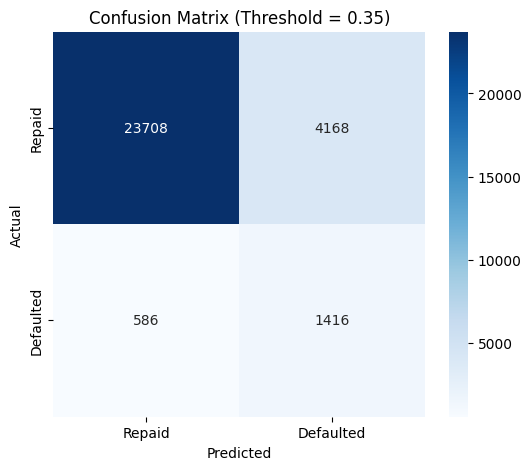

In [31]:
# Evaluation
model.eval()
y_val_probs = []

with torch.no_grad():
    for x_all, _ in val_loader:  
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_val_probs.extend(probs.cpu().numpy())

y_val_probs = np.array(y_val_probs)
prec, rec, thresholds = precision_recall_curve(y_val, y_val_probs)
best_thresh_a = threshold_by_target_recall(y_val, y_val_probs, thresholds, 0.69)

y_test_probs = []
with torch.no_grad():
    for x_all, _ in test_loader:
        x_all = x_all.to(device)
        outputs = model(x_all)
        probs = torch.sigmoid(outputs)
        y_test_probs.extend(probs.cpu().numpy())

y_test_probs = np.array(y_test_probs)
y_test_pred_opt = (y_test_probs > best_thresh_a).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_test_pred_opt, target_names=target_names)
acc = accuracy_score(y_test, y_test_pred_opt)
roc_auc = roc_auc_score(y_test, y_test_probs)
cm = confusion_matrix(y_test, y_test_pred_opt)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)

print("Best threshold:", best_thresh_a)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_a:.2f})")
plt.show()

In [32]:
# Model
best_param = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "scale_pos_weight": sum(y_train==0)/sum(y_train==1),
    "learning_rate": 0.02,
    "max_depth": 4,
    "min_child_weight": 5,
    "subsample": 0.85,
    "colsample_bytree": 0.85,
    "gamma": 1,
    "reg_alpha": 1,
    "reg_lambda": 2,
    "n_estimators": 1000,
    "random_state": 42,
    "n_jobs": -1,
    "tree_method": "hist", 
    "device": "cuda",
}

model_b = xgb.XGBClassifier(
    **best_param,
    early_stopping_rounds=100,
)

In [33]:
# Train
model_b.fit(X_train_xgb, y_train, eval_set=[(X_val_xgb, y_val)], verbose=True)

[0]	validation_0-auc:0.84710
[1]	validation_0-auc:0.84957
[2]	validation_0-auc:0.84984
[3]	validation_0-auc:0.85230
[4]	validation_0-auc:0.85268
[5]	validation_0-auc:0.85259
[6]	validation_0-auc:0.85232
[7]	validation_0-auc:0.85285
[8]	validation_0-auc:0.85262
[9]	validation_0-auc:0.85258
[10]	validation_0-auc:0.85256
[11]	validation_0-auc:0.85254
[12]	validation_0-auc:0.85250
[13]	validation_0-auc:0.85255
[14]	validation_0-auc:0.85234
[15]	validation_0-auc:0.85242
[16]	validation_0-auc:0.85245
[17]	validation_0-auc:0.85256
[18]	validation_0-auc:0.85259
[19]	validation_0-auc:0.85286
[20]	validation_0-auc:0.85287
[21]	validation_0-auc:0.85287
[22]	validation_0-auc:0.85295
[23]	validation_0-auc:0.85307
[24]	validation_0-auc:0.85318
[25]	validation_0-auc:0.85306
[26]	validation_0-auc:0.85308
[27]	validation_0-auc:0.85314
[28]	validation_0-auc:0.85321
[29]	validation_0-auc:0.85326
[30]	validation_0-auc:0.85344
[31]	validation_0-auc:0.85355
[32]	validation_0-auc:0.85364
[33]	validation_0-au

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.85
,device,'cuda'
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'auc'


Best threshold: 0.5866562128067017
              precision    recall  f1-score   support

      Repaid       0.98      0.86      0.92     27876
   Defaulted       0.27      0.70      0.39      2002

    accuracy                           0.85     29878
   macro avg       0.62      0.78      0.65     29878
weighted avg       0.93      0.85      0.88     29878

Accuracy: 85.07%
ROC AUC: 0.867
TP=1401, FP=3860, TN=24016, FN=601
Accuracy for class 'Repaid': 86.15%
Accuracy for class 'Defaulted': 69.98%


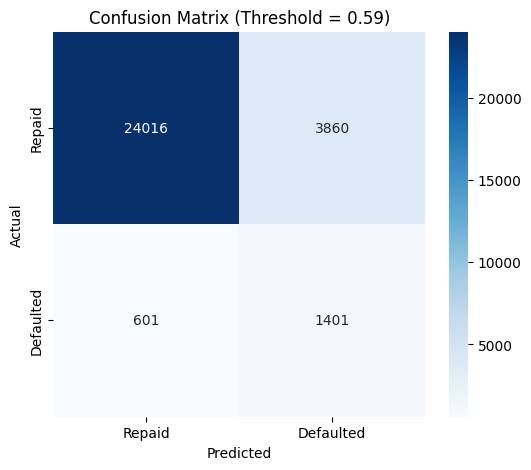

In [34]:
# Evaluation
dtest = xgb.DMatrix(X_test_xgb)
y_probs = model_b.get_booster().predict(dtest) 

# Target defaults recall
prec, rec, thresholds = precision_recall_curve(y_test, y_probs)
best_thresh_b = threshold_by_target_recall(y_test, y_probs, thresholds, 0.70)
y_pred = (y_probs > best_thresh_b).astype(int)

target_names = ['Repaid', 'Defaulted']
report = classification_report(y_test, y_pred, target_names=target_names)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
per_class_acc = cm.diagonal() / cm.sum(axis=1)
roc_auc = roc_auc_score(y_test, y_probs)

print("Best threshold:", best_thresh_b)
print(report)
print(f"Accuracy: {acc*100:.2f}%")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
for i, class_name in enumerate(target_names):
    print(f"Accuracy for class '{class_name}': {per_class_acc[i]*100:.2f}%")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Threshold = {best_thresh_b:.2f})")
plt.show()

In [35]:
# Shap xgb
explainer = shap.TreeExplainer(model_b)
shap_values = explainer.shap_values(X_train_xgb)
mean_abs_shap = np.abs(shap_values).mean(axis=0)

importance_df = pd.DataFrame({
    "Feature": X_train_xgb.columns,
    "Importance": mean_abs_shap
}).sort_values("Importance", ascending=False).reset_index(drop=True)

print("SHAP Importance:")
print(importance_df)

SHAP Importance:
                                Feature  Importance
0                      DelinquencyScore    0.544036
1                     UtilizationPerAge    0.459195
2           UtilizationTimesDelinquency    0.250997
3         RevolvingUtilizationCappedLog    0.236395
4                   IncomePerCreditLine    0.170037
5                   DebtToIncomeAgeRisk    0.146515
6                    TotalPastDueCapped    0.100847
7              UtilizationPerCreditLine    0.079334
8             LatePaymentsPerCreditLine    0.075929
9                     DelinquencyBucket    0.039941
10                      HighAgeRiskFlag    0.024212
11          UtilizationBucketLateBucket    0.020760
12                  HasMajorDelinquency    0.019139
13   WasUtilizationPerCreditLineImputed    0.000767
14          WasUtilizationPerAgeImputed    0.000243
15  WasLatePaymentsPerCreditLineImputed    0.000000
16        WasIncomePerCreditLineImputed    0.000000


In [36]:
# Shap NN
model_gpu = copy.deepcopy(model).to(device)
model_gpu.eval()

def shap_ohe_gpu(X):
    X_tensor = torch.tensor(X, dtype=torch.float32, device=device)
    with torch.no_grad():
        logits = model_gpu(X_tensor)
        probs = torch.sigmoid(logits).cpu().numpy()
    return probs

feature_names = list(X_train_nn_full.columns)
background = shap.sample(X_train_tensor.cpu().numpy(), 100)
explainer = shap.KernelExplainer(shap_ohe_gpu, background)
shap_values = explainer.shap_values(X_val_tensor[:500].cpu().numpy())
shap_values_array = np.array(shap_values)
mean_abs_shap = np.abs(shap_values_array).mean(axis=0)

importance_df = pd.DataFrame({
    "feature": feature_names,
    "mean_abs_shap": mean_abs_shap
}).sort_values(by="mean_abs_shap", ascending=False).reset_index(drop=True)

print("SHAP Importance:")
print(importance_df)

  0%|          | 0/500 [00:00<?, ?it/s]

SHAP Importance:
                                         feature  mean_abs_shap
0                              UtilizationPerAge       0.022644
1                         DelinquencyBucket_None       0.019653
2                  RevolvingUtilizationCappedLog       0.011754
3    UtilizationBucketLateBucket_Very Low_NoLate       0.008564
4                            DebtToIncomeAgeRisk       0.007983
5                            IncomePerCreditLine       0.007021
6         UtilizationBucketLateBucket_Low_NoLate       0.005145
7                            HasMajorDelinquency       0.003272
8                     DelinquencyBucket_Moderate       0.002945
9                        DelinquencyBucket_Other       0.002587
10             UtilizationBucketLateBucket_Other       0.002153
11                         DelinquencyBucket_Few       0.002116
12                      UtilizationPerCreditLine       0.001859
13                            TotalPastDueCapped       0.001845
14                     

In [37]:
# Save NN model
torch.save(model.state_dict(), "cr_weights.pth")

In [38]:
# Save xgb model
model_b.save_model("cr_b.json")

In [39]:
# Save for hosting
joblib.dump(X_train_xgb.columns.tolist(), "xgb_col_order.pkl")
joblib.dump(X_train_nn_full.columns.tolist(), "nn_col_order.pkl")
joblib.dump(best_thresh_a, "threshold_a.pkl")
joblib.dump(best_thresh_b, "threshold_b.pkl")
joblib.dump(num_imputer, "num_imputer.pkl")
joblib.dump(cat_imputer, "cat_imputer.pkl")
joblib.dump(robust_scaler, "robust_scaler.pkl")
joblib.dump(std_scaler, "std_scaler.pkl")
joblib.dump(num_col_order, "num_col_order.pkl")
joblib.dump(cat_maps, "cat_maps.pkl")
joblib.dump(cat_col_order, "cat_col_order.pkl")
joblib.dump(skewed_col_order, "skewed_col_order.pkl")
joblib.dump(rare_maps, "rare_maps.pkl")

['rare_maps.pkl']